# Setup

In [1]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'code_comprehension_related'
report_dict_list = []

# Dialogue Act Classifier Performance

In [2]:
from collections import defaultdict

precisions, recalls = dac_factory.get_precision_and_recall()
precisions_recalls = [precisions, recalls]

dac_report = {}
dac_report[''] = [None, None, dac_factory.get_accuracy()]
for label in precisions.keys():
  dac_report[label] = [i[label] for i in precisions_recalls]

df = DataFrame.from_dict(dac_report, orient='index', columns=['Precision', 'Recall', 'Accuracy'])

df

,Precision,Recall,Accuracy
,NaN,NaN,0.666667
Statement,0.666667,0.593023,NaN
Emotion,0.989247,0.666667,NaN
System,0.951456,0.911628,NaN
Greet,1.000000,0.804878,NaN
Accept,0.615385,0.216216,NaN
Reject,0.157895,0.166667,NaN
whQuestion,0.746269,0.769231,NaN
Continuer,0.000000,0.000000,NaN
ynQuestion,0.671429,0.734375,NaN


# Evenly distribute the training data labelled as "No" and "Yes".

In [3]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

X_train_evenly_dist = evenly_distrubted_training_dataset[FEATURES]
y_train_evenly_dist = evenly_distrubted_training_dataset[LABEL]

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

,Label (Yes),Label (No),Ratio (Yes)
Training Dataset,72,313,0.187013
Test Dataset,76,309,0.197403


# Set up

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

# CountVectorizer - SVC

In [5]:
from sklearn.svm import SVC

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_count_vectorizer',
            CountVectorizer(stop_words='english'),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

clf_svc = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - SVC

In [6]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Stemming - SVC

In [7]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_count_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SVC

In [8]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=0.1, probability=True))
    ],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SGDClassifier

In [9]:
from sklearn.linear_model import SGDClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier())
    ],
    verbose=False)

clf_sgd = full_pipeline

clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_sgd.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - KNeighborsClassifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', KNeighborsClassifier())
    ],
    verbose=False)

clf_kneighbors = full_pipeline

clf_kneighbors.fit(X_train, y_train)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_kneighbors.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', BaggingClassifier(base_estimator=LogisticRegression(C=500000, solver='lbfgs'), max_samples=0.5, max_features=0.5))
    ],
    verbose=False)

clf_ensemble = full_pipeline

clf_ensemble.fit(X_train, y_train)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_ensemble.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression) (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - MultinomialNB

In [12]:
from sklearn.naive_bayes import MultinomialNB

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_multinominal_nb.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - LogisticRegression

In [13]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='lbfgs'))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - DecisionTree

In [14]:
from sklearn.tree import DecisionTreeClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier())],
    verbose=False)

clf_decision_tree = full_pipeline

clf_decision_tree.fit(X_train, y_train)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_decision_tree.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# CodeComprehensionClassifierFactory

In [15]:
from classifier import CodeComprehensionClassifierFactory

clf_optimal = CodeComprehensionClassifierFactory.get_classifier(dac_labels)

clf_optimal.fit(X_train, y_train)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_optimal.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Tuning the model with Grid Search

In [16]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='lbfgs'))],
    verbose=False)

yes_f1_scorer = metrics.make_scorer(metrics.f1_score, pos_label="Yes")

grid_search_cv_params = [
    {'preprocessor__body_tfidf_vectorizer__tokenizer': [None, LemmaTokenizer()]},
    {'preprocessor__body_tfidf_vectorizer__stop_words': [None, 'english']},
    {'preprocessor__body_tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]},
    {
        'preprocessor__transformer_weights': [
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 2},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 100},          
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 6},
        ]
    },
    {'classifier__C': [0.1, 1, 2, 500000]},    
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_f1_scorer, return_train_score=True, n_jobs=-1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

{'preprocessor__transformer_weights': {'body_tfidf_vectorizer': 4,
  'dac_transformer': 6,
  'is_author_transformer': 100}}

In [17]:
df = DataFrame(clf_grid_search_cv.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__body_tfidf_vectorizer__tokenizer,param_preprocessor__body_tfidf_vectorizer__stop_words,param_preprocessor__body_tfidf_vectorizer__ngram_range,param_preprocessor__transformer_weights,param_classifier__C,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.224215,0.045848,0.031376,0.020980,None,NaN,NaN,NaN,NaN,{'preprocessor__body_tfidf_vectorizer__tokeniz...,...,0.277522,0.146457,39,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,8.841794,2.058949,1.078666,1.966888,<nlp.LemmaTokenizer.LemmaTokenizer object at 0...,NaN,NaN,NaN,NaN,{'preprocessor__body_tfidf_vectorizer__tokeniz...,...,0.539882,0.151929,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,7.099358,3.615119,1.967346,3.724837,NaN,None,NaN,NaN,NaN,{'preprocessor__body_tfidf_vectorizer__stop_wo...,...,0.528253,0.150111,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,8.328957,3.895289,2.086150,3.743438,NaN,english,NaN,NaN,NaN,{'preprocessor__body_tfidf_vectorizer__stop_wo...,...,0.539882,0.151929,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,6.429972,3.152865,1.396135,2.465899,NaN,NaN,"(1, 1)",NaN,NaN,{'preprocessor__body_tfidf_vectorizer__ngram_r...,...,0.437051,0.085352,38,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,5.673307,2.513274,1.813668,3.417464,NaN,NaN,"(1, 2)",NaN,NaN,{'preprocessor__body_tfidf_vectorizer__ngram_r...,...,0.539882,0.151929,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,7.032918,3.479770,1.167356,2.122486,NaN,NaN,"(1, 3)",NaN,NaN,{'preprocessor__body_tfidf_vectorizer__ngram_r...,...,0.483333,0.156290,31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,5.425873,2.315995,1.134705,2.042962,NaN,NaN,"(1, 5)",NaN,NaN,{'preprocessor__body_tfidf_vectorizer__ngram_r...,...,0.499168,0.164389,26,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,4.582686,2.063497,1.081787,1.966459,NaN,NaN,"(2, 2)",NaN,NaN,{'preprocessor__body_tfidf_vectorizer__ngram_r...,...,0.235180,0.014112,40,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,4.916262,2.166435,1.200363,2.182801,NaN,NaN,"(2, 3)",NaN,NaN,{'preprocessor__body_tfidf_vectorizer__ngram_r...,...,0.182092,0.060272,45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [18]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [19]:
from matplotlib import pyplot

x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,CountVectorizer - SVC,0.829412,0.912621,0.869029,0.400000,0.236842,0.297521,0.779221
1,CountVectorizer - SVC (Evenly Distributed),0.856459,0.579288,0.691120,0.261364,0.605263,0.365079,0.584416
2,TFIDF - SVC,0.819444,0.954693,0.881913,0.440000,0.144737,0.217822,0.794805
3,TFIDF - SVC (Evenly Distributed),0.880000,0.640777,0.741573,0.306250,0.644737,0.415254,0.641558
4,TFIDF - Stemming - SVC,0.821333,0.996764,0.900585,0.900000,0.118421,0.209302,0.823377
5,TFIDF - Stemming - SVC (Evenly Distributed),0.921053,0.566343,0.701403,0.312821,0.802632,0.450185,0.612987
6,TFIDF - Lemmatization - SVC,0.898462,0.944984,0.921136,0.716667,0.565789,0.632353,0.870130
7,TFIDF - Lemmatization - SVC (Evenly Distributed),0.924000,0.747573,0.826476,0.422222,0.750000,0.540284,0.748052
8,TFIDF - Lemmatization - SGDClassifier,0.889571,0.938511,0.913386,0.677966,0.526316,0.592593,0.857143
9,TFIDF - Lemmatization - SGDClassifier (Evenly ...,0.922330,0.614887,0.737864,0.335196,0.789474,0.470588,0.649351


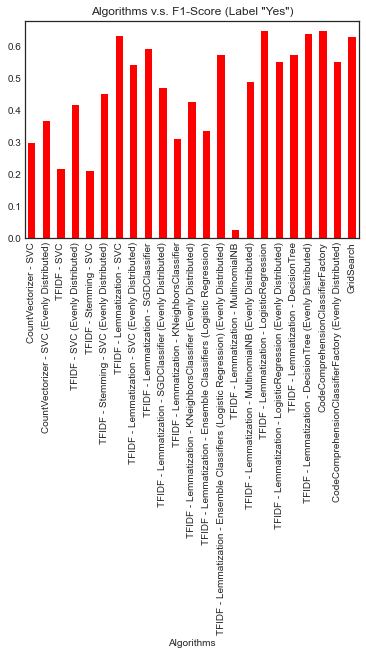

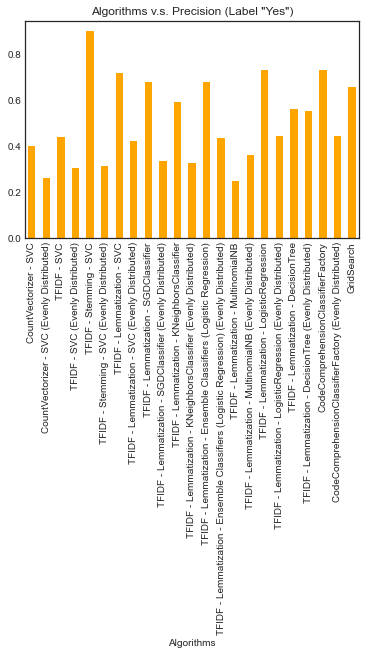

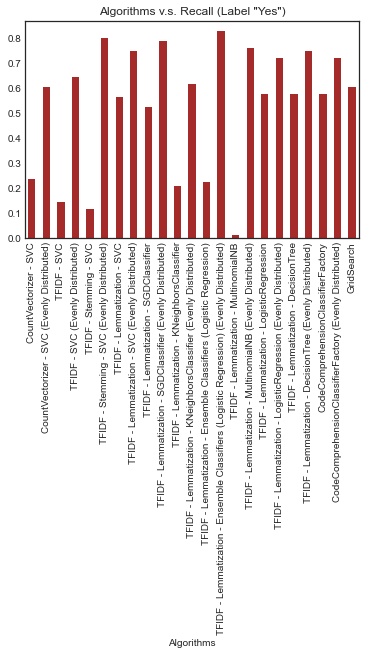

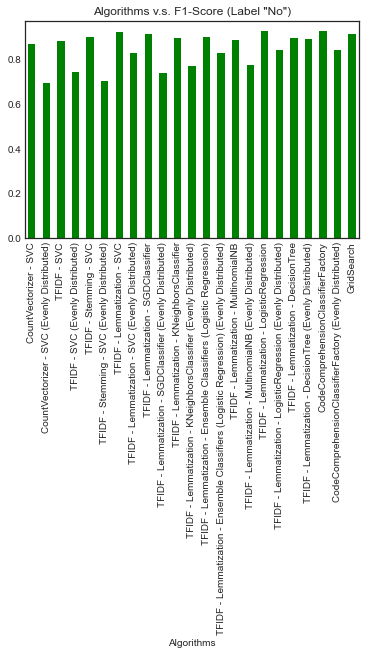

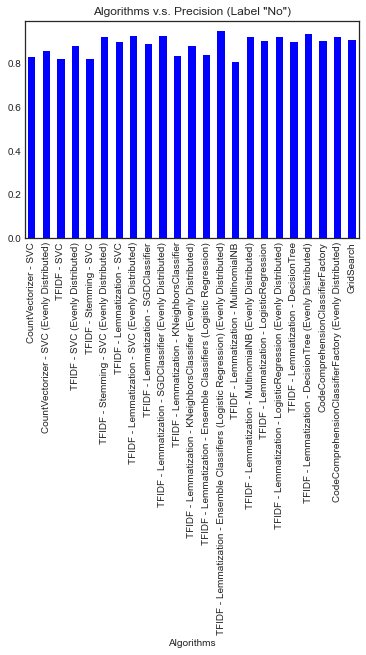

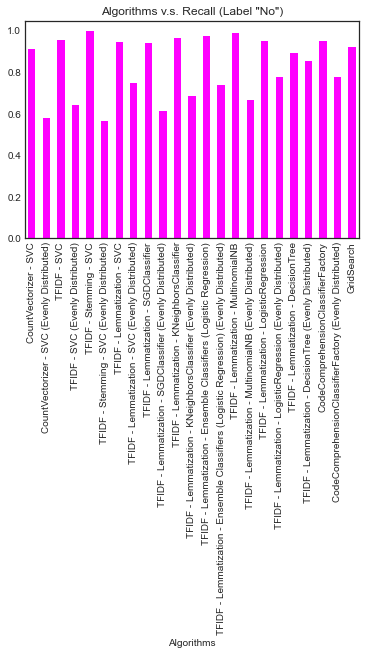

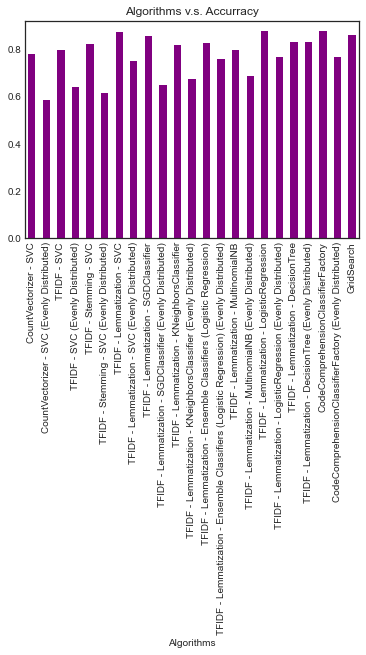

In [20]:
with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)